In [1]:
from google.colab import files
uploaded =files.upload()

Saving dataset.csv to dataset.csv


In [2]:
#  Required Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import folium

#  Load Dataset
df = pd.read_csv("dataset.csv")

#  Combine Date + Time into Timestamp
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], dayfirst=True)
df = df.sort_values(by='timestamp')
df['hour'] = df['timestamp'].dt.hour

#  Encode Categorical Features
df['TrafficLevelNum'] = df['TrafficConditionNearby'].map({'low': 1, 'medium': 2, 'high': 3})
df['VehicleWeight'] = df['VehicleType'].map({'car': 1.0, 'bike': 0.5, 'truck': 1.5})


In [3]:
#  Model 1 - Occupancy Based Linear Pricing
base_price = 10.0
min_price, max_price = 5.0, 20.0
alpha1 = 2.0  # Controls price rise with occupancy

model1_results = []

for lot_id in df['SystemCodeNumber'].unique():
    df_lot = df[df['SystemCodeNumber'] == lot_id].copy().sort_values('timestamp')
    prices = []
    prev_price = base_price

    for _, row in df_lot.iterrows():
        if row['Capacity'] == 0:
            new_price = prev_price
        else:
            new_price = prev_price + alpha1 * (row['Occupancy'] / row['Capacity'])

        new_price = max(min(new_price, prev_price + 1.5), prev_price - 1.5)
        new_price = max(min(new_price, max_price), min_price)
        prices.append(new_price)
        prev_price = new_price

    df_lot['Model1Price'] = prices
    model1_results.append(df_lot)

df = pd.concat(model1_results).reset_index(drop=True)


In [4]:
#  Model 2 - Demand-Based Dynamic Pricing

# Demand weight parameters
α, β, γ, δ, ε = 0.4, 0.2, 0.3, 1.0, 0.5
λ = 0.5  # Demand sensitivity to price

# Normalize input features
df['NormOccupancy'] = df['Occupancy'] / df['Capacity']
df['NormQueue'] = df['QueueLength'] / df['QueueLength'].max()
df['NormTraffic'] = df['TrafficLevelNum'] / df['TrafficLevelNum'].max()
df['NormVehicle'] = df['VehicleWeight'] / df['VehicleWeight'].max()

# Demand function
df['Demand'] = (
    α * df['NormOccupancy'] +
    β * df['NormQueue'] -
    γ * df['NormTraffic'] +
    δ * df['IsSpecialDay'] +
    ε * df['NormVehicle']
)

# Normalize demand to [0, 1]
d_min, d_max = df['Demand'].min(), df['Demand'].max()
df['NormDemand'] = (df['Demand'] - d_min) / (d_max - d_min + 1e-5)

# Final demand-based price
df['Model2Price'] = base_price * (1 + λ * df['NormDemand'])
df['Model2Price'] = df['Model2Price'].clip(lower=min_price, upper=max_price)


In [5]:
#  Model 3 - Competition-Aware Pricing

# Step 1: Haversine Distance Function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# Step 2: Precompute Nearby Lots within 0.5km
coords = df.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first().to_dict('index')
nearby_lots = {
    l1: [
        l2 for l2 in coords
        if l1 != l2 and haversine(coords[l1]['Latitude'], coords[l1]['Longitude'],
                                  coords[l2]['Latitude'], coords[l2]['Longitude']) <= 0.5
    ]
    for l1 in coords
}

# Step 3: Apply Competitive Pricing and Reroute Logic
df['Model3Price'] = df['Model2Price']
df['RerouteSuggested'] = 0

for ts in df['timestamp'].unique():
    df_ts = df[df['timestamp'] == ts]
    for lot_id in df_ts['SystemCodeNumber'].unique():
        current = df_ts[df_ts['SystemCodeNumber'] == lot_id].iloc[0]
        nearby = nearby_lots.get(lot_id, [])
        curr_price = current['Model2Price']
        new_price, reroute = curr_price, 0

        if current['QueueLength'] > 3 or current['Occupancy'] >= current['Capacity']:
            for comp_id in nearby:
                comp = df_ts[df_ts['SystemCodeNumber'] == comp_id]
                if not comp.empty and comp.iloc[0]['Model2Price'] < curr_price and comp.iloc[0]['Occupancy'] < comp.iloc[0]['Capacity']:
                    new_price = max(curr_price * 0.8, 5.0)
                    reroute = 1
                    break
        else:
            if all(df_ts[df_ts['SystemCodeNumber'] == nid].iloc[0]['Model2Price'] >= curr_price for nid in nearby if not df_ts[df_ts['SystemCodeNumber'] == nid].empty):
                new_price = min(curr_price * 1.2, 20.0)

        df.loc[(df['timestamp'] == ts) & (df['SystemCodeNumber'] == lot_id), 'Model3Price'] = new_price
        df.loc[(df['timestamp'] == ts) & (df['SystemCodeNumber'] == lot_id), 'RerouteSuggested'] = reroute


In [6]:
#  Clean Final Output for Submission
final_df = df[['timestamp', 'SystemCodeNumber', 'Occupancy', 'QueueLength',
               'Model1Price', 'Model2Price', 'Model3Price', 'RerouteSuggested']].copy()

# Rename columns
final_df.columns = ['timestamp', 'lot_id', 'occupancy', 'queue',
                    'model1_price', 'model2_price', 'model3_price', 'reroute_flag']

# Save to CSV
final_df.to_csv("final_output.csv", index=False)
final_df.head(5)  # Preview the cleaned output


,timestamp,lot_id,occupancy,queue,model1_price,model2_price,model3_price,reroute_flag
0,2016-10-04 07:59:00,BHMBCCMKT01,61,1,10.211438,10.864987,13.037985,0
1,2016-10-04 08:25:00,BHMBCCMKT01,64,1,10.433276,10.870691,10.870691,0
2,2016-10-04 08:59:00,BHMBCCMKT01,80,2,10.710572,10.937682,13.125219,0
3,2016-10-04 09:32:00,BHMBCCMKT01,107,2,11.081456,10.989019,10.989019,0
4,2016-10-04 09:59:00,BHMBCCMKT01,150,2,11.601386,10.613661,12.736393,0


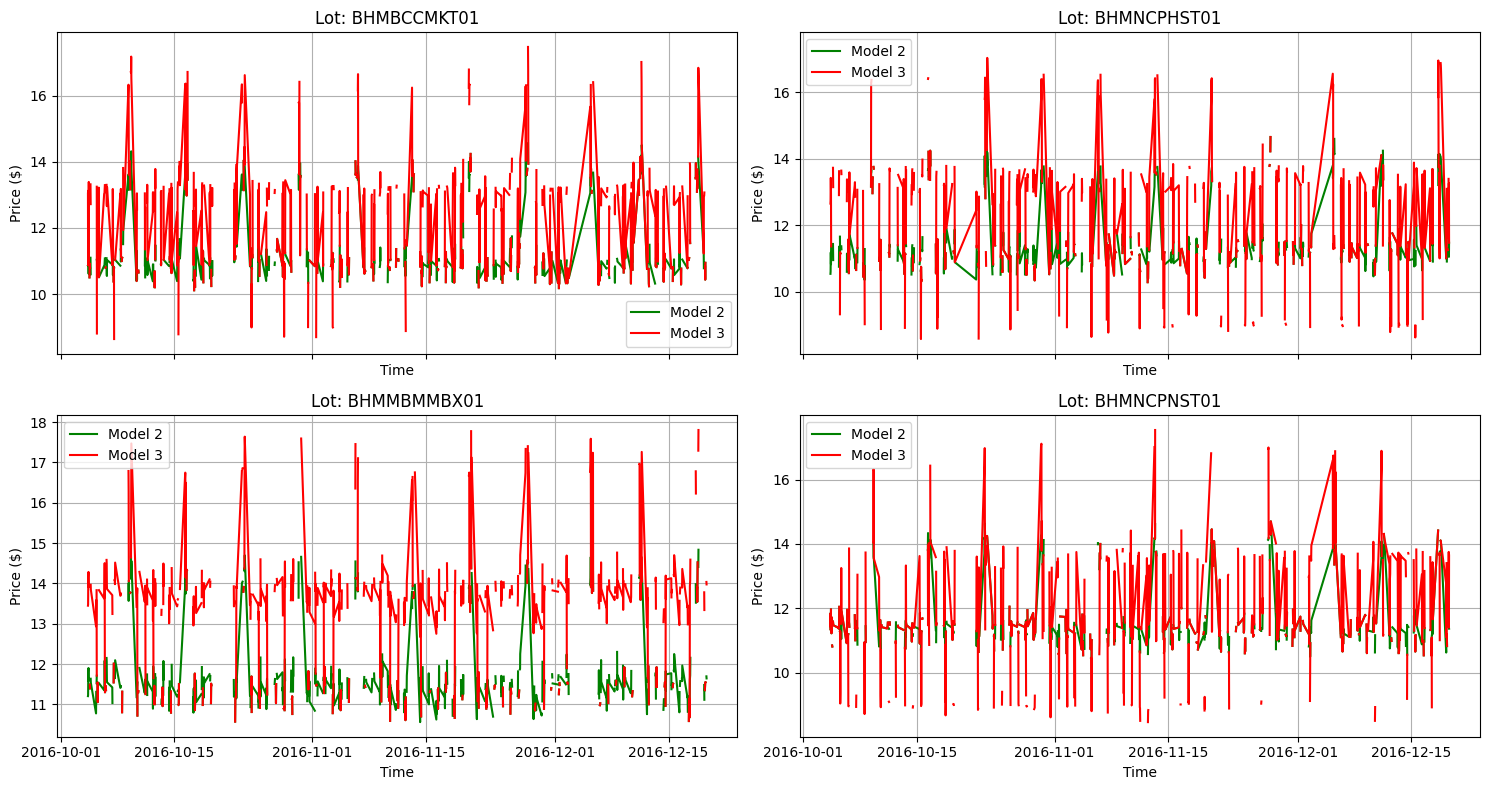

In [7]:
# Pick 4 lots to compare
import matplotlib.pyplot as plt
selected_lots = final_df['lot_id'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for i, lot in enumerate(selected_lots):
    df_lot = final_df[final_df['lot_id'] == lot]
    axes[i].plot(df_lot['timestamp'], df_lot['model2_price'], label='Model 2', color='green')
    axes[i].plot(df_lot['timestamp'], df_lot['model3_price'], label='Model 3', color='red')
    axes[i].set_title(f"Lot: {lot}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Price ($)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [9]:
import folium

# Filter rerouted lots
reroutes = final_df[final_df['reroute_flag'] == 1]
reroutes_latest = reroutes.sort_values(by='timestamp').groupby('lot_id').tail(1)

# Merge latitude and longitude from the original df
lot_coords = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().rename(columns={'SystemCodeNumber': 'lot_id'})
reroutes_latest = pd.merge(reroutes_latest, lot_coords, on='lot_id', how='left')


# Average center for map
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
reroute_map = folium.Map(location=map_center, zoom_start=13)

# Add reroute markers
for _, row in reroutes_latest.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Lot: {row['lot_id']}<br>Queue: {row['queue']}<br>Price: ${row['model3_price']:.2f}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(reroute_map)

# Save map
reroute_map.save("reroute_map.html")
reroute_map  # Will render inline in Colab

In [11]:
from google.colab import files

# Download key files
files.download("final_output.csv")
files.download("reroute_map.html")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>